In [1]:
import tensorflow
import numpy as np
import pandas as pd
import os
import tensorflow.keras as keras
import h5py
zip_file=keras.utils.get_file(
    fname="gamma_angle_position_5deg_xy.h5",
    origin="https://zenodo.org/record/846388/files/gamma_angle_position_5deg_xy.h5?download=1",
    extract=True

)
dirnam=os.path.join(os.path.dirname(zip_file), "gamma_angle_position_5deg_xy.h5")
zip_file


'/root/.keras/datasets/gamma_angle_position_5deg_xy.h5'

In [2]:
#Data Import
layer_0_data = (np.array(h5py.File(zip_file)["layer_0"][:]))
layer_1_data = (np.array(h5py.File(zip_file)["layer_1"][:]))
y=np.copy(layer_1_data)
layer_2_data = (np.array(h5py.File(zip_file)["layer_2"][:]))
energy=(np.array(h5py.File(zip_file)["energy"]))
energy=energy.reshape(energy.shape[0])
print(layer_0_data.shape)

nrm_l0=np.max(layer_0_data)
nrm_l1=np.max(layer_1_data)
nrm_l2=np.max(layer_2_data)
nrm_e=np.max(energy)

rng = np.random.default_rng()
noise_l0 = rng.normal(0,167,layer_0_data.shape[0]*layer_0_data.shape[1]*layer_0_data.shape[2])
noise_l0 = noise_l0.reshape(layer_0_data.shape[0],layer_0_data.shape[1],layer_0_data.shape[2])
layer_0_data = layer_0_data + noise_l0
layer_0_data[layer_0_data<0] = 0

noise_l1 = rng.normal(0,167,layer_1_data.shape[0]*layer_1_data.shape[1]*layer_1_data.shape[2])
noise_l1 = noise_l1.reshape(layer_1_data.shape[0],layer_1_data.shape[1],layer_1_data.shape[2])
layer_1_data = layer_1_data + noise_l1
layer_1_data[layer_1_data<0] = 0

noise_l2 = rng.normal(0,167,layer_2_data.shape[0]*layer_2_data.shape[1]*layer_2_data.shape[2])
noise_l2 = noise_l2.reshape(layer_2_data.shape[0],layer_2_data.shape[1],layer_2_data.shape[2])
layer_2_data = layer_2_data + noise_l2
layer_2_data[layer_2_data<0] = 0

Layer_0_data_preprocessed=layer_0_data/nrm_l0
Layer_1_data_preprocessed=layer_1_data/nrm_l1
Layer_2_data_preprocessed=layer_2_data/nrm_l2
energy = energy / nrm_e


(500000, 3, 96)


In [3]:
#Alternative Gaussian Noise Adding Function
def noise_add(layer_name, alpha, noise):
    noise_ln = rng.normal(alpha, noise ,layer_name.shape[0]*layer_name.shape[1]*layer_name.shape[2])
    noise_ln = noise_ln.reshape(layer_name.shape[0],layer_name.shape[1],layer_name.shape[2])
    layer_name = layer_name + noise_ln
    layer_name[layer_name<0] = 0
noise_add(layer_0_data,0,167)
noise_add(layer_1_data,0,167)
noise_add(layer_2_data,0,167)

In [4]:
#DNN Preprocess-1
flatten_layer_0=Layer_0_data_preprocessed.reshape(500000,3*96)
flatten_layer_1=Layer_1_data_preprocessed.reshape(500000,12*12)
flatten_layer_2=Layer_2_data_preprocessed.reshape(500000,6*12)
#from random import randint
#random_selection=np.array([x for x in range (500000) if x not in random])

In [5]:
#Train-Test Split
from sklearn.model_selection import train_test_split
layer_0_train, layer_0_test, energy_train, energy_test,  layer_1_train,layer_1_test, layer_2_train, layer_2_test,= train_test_split(flatten_layer_0,  energy, flatten_layer_1, flatten_layer_2,  test_size=0.4, random_state=42)
layer_0_train_2D, layer_0_test_2D, energy_train, energy_test,  layer_1_train_2D,layer_1_test_2D, layer_2_train_2D, layer_2_test2D,= train_test_split(Layer_0_data_preprocessed,  energy, Layer_1_data_preprocessed, Layer_2_data_preprocessed,  test_size=0.4, random_state=42)

In [6]:
#DNN Preprocess-2
lc1_test=np.array([np.concatenate((layer_0_test, layer_1_test, layer_2_test),axis=1)  ])
lc1_train=np.array([np.concatenate((layer_0_train, layer_1_train, layer_2_train),axis=1)  ])
lc1_train=lc1_train.reshape(lc1_train.shape[1],lc1_train.shape[2])
lc1_test=lc1_test.reshape(lc1_test.shape[1],lc1_test.shape[2])

In [7]:
#Model Run Mechanism
def run_experiment(model, x_train, y_train):
    
    model.compile(
        optimizer=keras.optimizers.Adam(0.003),
        loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")#,
        #metrics=tf.keras.metrics.BinaryAccuracy(),
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, restore_best_weights=True
    )
    
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=50,
        batch_size=2028,
        validation_split=0.2,
        callbacks=[early_stopping],
    )

    return history

In [8]:
#DNN
import keras.layers as layers
import tensorflow as tf
hidden_units = [1024, 512,64]
def dnn(hidden_units, num_classes, dropout_rate):
    inputs = layers.Input(shape=(144+(96*3)+72,), name="input_features")
    x = inputs
    for units in hidden_units:        
        x  = layers.Dense(units, activation=tf.nn.relu)(x)
        x  = layers.Dropout(rate=dropout_rate)(x)
    logits = layers.Dense(num_classes, name="output")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="dnn")


dnn_model = dnn(hidden_units, 1, 0)
dnn_model.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer)  [(None, 504)]            0         
                                                                 
 dense (Dense)               (None, 1024)              517120    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0       

In [9]:
#CNN
def cnn(hidden_units, num_classes, dropout_rate):
    inputs0 = layers.Input(shape=(3,96,1,), name="input_features_l0")
    inputs1 = layers.Input(shape=(12,12,1,), name="input_features_l1")
    inputs2 = layers.Input(shape=(12,6,1,), name="input_features_l2")
    cnn0 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs0)
    cnn0 = layers.Conv2D(64, 3, activation='relu')(cnn0)
    # cnn0 = layers.Conv2D(64, 5, activation='relu')(cnn0)
    cnn0 = layers.Flatten()(cnn0)
    inputs0_flat = layers.Flatten()(inputs0)
    cnn0Comb = layers.Concatenate()([cnn0,inputs0_flat])
    cnn1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs1)
    cnn1 = layers.Conv2D(64, 3, activation='relu')(cnn1)
    cnn1 = layers.Conv2D(128, 5, activation='relu')(cnn1)
    cnn1 = layers.Flatten()(cnn1)
    inputs1_flat = layers.Flatten()(inputs1)
    cnn1Comb = layers.Concatenate()([cnn1,inputs1_flat])
    cnn2 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs2)
    cnn2 = layers.Conv2D(64, 3, activation='relu')(cnn2)  
    cnn2 = layers.Conv2D(128, 3, activation='relu')(cnn2)      
    cnn2 = layers.Flatten()(cnn2)
    inputs2_flat = layers.Flatten()(inputs2)
    cnn2Comb = layers.Concatenate()([cnn2,inputs2_flat])
    x =  layers.Concatenate()([cnn0Comb,cnn1Comb,cnn2Comb])
    for units in hidden_units:        
        x  = layers.Dense(units, activation=tf.nn.relu)(x)
        x  = layers.Dropout(rate=dropout_rate)(x)
    logits = layers.Dense(num_classes, name="output")(x)
    # Create the model.
    return keras.Model(inputs=(inputs0,inputs1,inputs2), outputs=logits, name="dnn")

In [10]:
cnn_model = cnn(hidden_units, 1, 0.1)
cnn_model.summary()

Model: "dnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features_l1 (InputLayer)  [(None, 12, 12, 1)]  0          []                               
                                                                                                  
 input_features_l2 (InputLayer)  [(None, 12, 6, 1)]  0           []                               
                                                                                                  
 input_features_l0 (InputLayer)  [(None, 3, 96, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 12, 32)   320         ['input_features_l1[0][0]']      
                                                                                                

In [11]:
#DNN Training
x_train=lc1_train
y_train=energy_train
history_dnn=run_experiment(dnn_model, x_train, y_train)

Epoch 1/50
119/119 [==============================] - 4s 18ms/step - loss: 0.0268 - val_loss: 8.4869e-04
Epoch 2/50
119/119 [==============================] - 2s 15ms/step - loss: 4.9863e-04 - val_loss: 2.8432e-04
Epoch 3/50
119/119 [==============================] - 2s 15ms/step - loss: 2.4763e-04 - val_loss: 1.8459e-04
Epoch 4/50
119/119 [==============================] - 2s 15ms/step - loss: 1.8674e-04 - val_loss: 1.4952e-04
Epoch 5/50
119/119 [==============================] - 2s 14ms/step - loss: 1.6429e-04 - val_loss: 1.3928e-04
Epoch 6/50
119/119 [==============================] - 2s 14ms/step - loss: 1.5575e-04 - val_loss: 1.4311e-04
Epoch 7/50
119/119 [==============================] - 2s 14ms/step - loss: 1.5106e-04 - val_loss: 1.2729e-04
Epoch 8/50
119/119 [==============================] - 2s 14ms/step - loss: 1.4757e-04 - val_loss: 1.2627e-04
Epoch 9/50
119/119 [==============================] - 2s 15ms/step - loss: 1.4449e-04 - val_loss: 1.2494e-04
Epoch 10/50
119/119 [==

In [12]:
#CNN Training
history_cnn=run_experiment(cnn_model,[layer_0_train_2D,l ayer_1_train_2D,layer_2_train_2D],energy_train)

Epoch 1/50
119/119 [==============================] - 40s 278ms/step - loss: 0.1183 - val_loss: 2.5128e-04
Epoch 2/50
119/119 [==============================] - 31s 263ms/step - loss: 0.0038 - val_loss: 3.2150e-04
Epoch 3/50
119/119 [==============================] - 31s 260ms/step - loss: 0.0032 - val_loss: 5.6292e-04
Epoch 4/50
119/119 [==============================] - 31s 260ms/step - loss: 0.0030 - val_loss: 3.7448e-04
Epoch 5/50
119/119 [==============================] - 31s 260ms/step - loss: 0.0028 - val_loss: 4.0635e-04
Epoch 6/50
119/119 [==============================] - 31s 260ms/step - loss: 0.0026 - val_loss: 4.8449e-04
Epoch 7/50
119/119 [==============================] - 31s 260ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 8/50
119/119 [==============================] - 31s 260ms/step - loss: 0.0022 - val_loss: 8.7241e-04
Epoch 9/50
119/119 [==============================] - 31s 260ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 10/50
119/119 [========================

In [13]:
#CNN Prediction
cnn_predict=cnn_model.predict(x=[layer_0_test_2D,layer_1_test_2D,layer_2_test2D],verbose=1)
dnn_predict = dnn_model.predict(x=lc1_test, verbose=1)

6250/6250 [==============================] - 10s 2ms/step


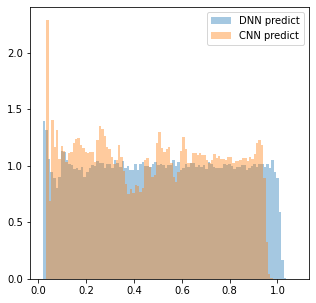

In [19]:
#Model Predictions
energy = np.array(energy)
dnn_predict = np.array(dnn_predict)
cnn_predict = np.array(cnn_predict)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=[5,5])
algo=np.sum(layer_0_test[energy_test>0],axis=1)*nrm_l0+np.sum(layer_1_test[energy_test>0],axis=1)*nrm_l1+np.sum(layer_2_test[energy_test>0],axis=1)*nrm_l2
#ax.hist(algo,bins= 100, density= True, label="Sum energy") 
ax.hist(dnn_predict,bins= 100, density = True , alpha = 0.4,  label="DNN predict")
ax.hist(cnn_predict,bins= 100, density = True, alpha = 0.4, label="CNN predict")

plt.legend() 


In [ ]:
#Training Performance
import matplotlib.pyplot as plt
fig, (ax) = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(history_dnn.history["loss"])
ax[0].plot(history_dnn.history["val_loss"])
ax[0].legend(["train", "val"],fontsize=15, loc="upper right")
ax[0].set_xlabel("Training Epochs",fontsize=15)
ax[0].set_ylabel("Loss(MSE)", fontsize=15)
ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[1].plot(history_cnn.history["loss"])
ax[1].plot(history_cnn.history["val_loss"])
ax[1].legend(["train", "val"],fontsize=15, loc="upper right")
ax[1].set_xlabel("Training Epochs",fontsize=15)
ax[1].set_ylim(top  = 0.006, bottom = 0.0)
ax[0].set_ylim(top  = 0.006, bottom = 0.0)
plt.show()

In [19]:
#Energy Resolution Distribution
dnn_predict = dnn_predict.reshape(dnn_predict.shape[0])
energy_cut  = 0 / (nrm_e * 1000)
dnn_diff_pred = (dnn_predict[energy_test>energy_cut] - energy_test[energy_test>energy_cut])/ energy_test[energy_test>energy_cut]
diff_sum = (np.sum(layer_0_test[energy_test>energy_cut],axis=1)*nrm_l0+np.sum(layer_1_test[energy_test>energy_cut],axis=1)*nrm_l1+np.sum(layer_2_test[energy_test>energy_cut],axis=1)*nrm_l2 - energy_test[energy_test>energy_cut]*nrm_e*1000 + 0.0068*energy_test[energy_test>energy_cut]*nrm_e*1000)/(energy_test[energy_test>energy_cut]*nrm_e*1000)
print(np.argmin(diff_sum))
print(np.sum(diff_sum>0))

print(np.std(dnn_diff_pred))
print(np.std(diff_sum))
print(np.mean(dnn_diff_pred))
print(np.mean(diff_sum))

141083
199971
0.07071936773431463
2.943261827966066
-0.018267973349515926
1.5026923280228004


In [20]:
#CNN Energy Resolution
cnn_predict=np.array([cnn_predict]).reshape(200000)
cnn_diff_predict=(cnn_predict[energy_test>energy_cut]-energy_test[energy_test>energy_cut])/energy_test[energy_test>energy_cut]

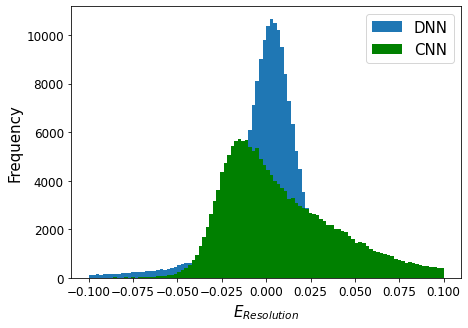

In [66]:
fig, ax = plt.subplots(1,1,figsize=[7,5])
ax.hist(dnn_diff_pred, bins = 100, range=[-0.1,0.1], label = "DNN") 
ax.hist(cnn_diff_predict,  bins = 100, range=[-0.1,0.1],color="g", label = "CNN") 
ax.set_ylabel("Frequency", fontsize=15)
ax.tick_params(labelsize=12)
ax.set_xlabel("$E_{\t{Resolution}}$", fontsize=15)
ax.legend(fontsize=15)

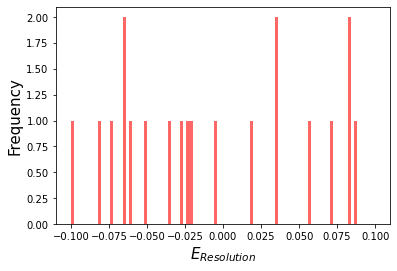

In [72]:
#Sum-Algo Energy Resolution
plt.hist(diff_sum, alpha = 0.6, bins = 100, range=[-0.1,0.1], label = "sum algo", color="r")
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("$E_{\t{Resolution}}$", fontsize=15)
plt.tick_params(labelsize=10)


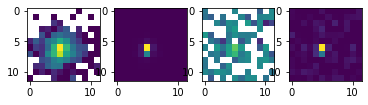

In [65]:
#Log-Normalized Data
from matplotlib.colors import LogNorm
def log_normalized_figures(n):
    fig, ax=plt.subplots(1,4)
    ax[0].imshow(y[n], norm=LogNorm(vmin=1, vmax=np.max(y[n])))
    ax[1].imshow(y[n])
    ax[2].imshow(layer_1_data[n], norm=LogNorm(vmin=1, vmax=np.max(layer_1_data[1])))
    ax[3].imshow(layer_1_data[n])
    plt.show()
log_normalized_figures(100)